In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mplcursors
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util.f_ring import (compute_corrected_ew, 
                                fit_hg_phase_function, 
                                hg_func,
                                print_hg_params)

%matplotlib notebook

# Utility Functions

In [30]:
### READ EW STATS AND OBS_LIST RESTRICTIONS

def read_obs_list():
    global OBS_LIST
    OBS_LIST = pd.read_csv('../obs_list.csv', parse_dates=['Date'], index_col='Observation')
    
def read_ew_stats(filename):
    obsdata = pd.read_csv(filename, parse_dates=['Date'])
    obsdata = obsdata.join(OBS_LIST, on='Observation', rsuffix='_obslist')
    obsdata = obsdata[obsdata['For Photometry'] == 1]
    print(f'** SUMMARY STATISTICS - {filename} **')
    print('Unique observation names:', len(obsdata.groupby('Observation')))
    print('Total slices:', len(obsdata))
    print('Starting date:', obsdata['Date'].min())
    print('Ending date:', obsdata['Date'].max())
    print('Time span:', obsdata['Date'].max()-obsdata['Date'].min())
    obsdata['Mu'] = np.abs(np.cos(np.radians(obsdata['Mean Emission'])))
    obsdata['Mu0'] = np.abs(np.cos(np.radians(obsdata['Incidence'])))
    return obsdata


### CALCULATE QUANTILES


def limit_by_quant(obsdata, cutoff1, cutoff2):
    def xform_func(column):
        if quant2 is None:
            return [(None if z > quant1[column.name] else z) for z in column]
        return [(None if z > quant1[column.name] or
                         z < quant2[column.name] else z) for z in column]
    obsdata = obsdata.copy()
    group = obsdata.groupby('Observation')
    quant1 = group.quantile(cutoff1/100, numeric_only=True)['Normal EW Mean']
    quant2 = None
    if cutoff2 is not None:
        quant2 = group.quantile(cutoff2/100, numeric_only=True)['Normal EW Mean']
    xform = group['Normal EW Mean'].transform(xform_func)
    obsdata['_control'] = xform
    obsdata.dropna(inplace=True)
    return obsdata
    

### SINGLE PLOTS - POINTS

def plot_various_quants(obsdata, include_phase=True):
    """Choose various quantiles of NormalEW and plot w/phase curves."""
    fig, axs = plt.subplots(4, 2, figsize=(10, 8))
    for plot_num, (perc1, perc2, color) in enumerate(((100, None, 'red'),
                                                      ( 85, None, 'orange'),
                                                      ( 75, None, 'green'),
                                                      ( 50, None, 'cyan'),
                                                      ( 25, None, 'blue'),
                                                      ( 15, None, 'black'),
                                                      ( 85,   15, 'brown'),
                                                      ( 75,   25, 'purple'))):
        ax = axs[plot_num // 2, plot_num % 2]
        quant_obsdata = limit_by_quant(obsdata, perc1, perc2)
        ax.scatter(quant_obsdata['Mean Phase'], quant_obsdata['Normal EW Mean'], marker='o', 
                   s=5, color=color, alpha=1, label=f'{perc1} / {perc2}')
        if include_phase:
            params, _, _ = fit_hg_phase_function(2, None, quant_obsdata)
            print(f'*** {perc1} / {perc2}: {color}')
            print_hg_params(params)
            xrange = np.arange(quant_obsdata['Mean Phase'].min(), quant_obsdata['Mean Phase'].max()+1)
            full_phase_model = hg_func(params, xrange)
            lcolor = 'black' if color != 'black' else 'grey'
            ax.plot(xrange, full_phase_model, '-', color=lcolor, lw=3)
        ax.set_yscale('log')
        ax.set_xlim(0, 180)
        ax.set_xlabel('Phase Angle (°)')
        ax.set_ylabel('Normal EW')
        ax.legend()
    plt.tight_layout()
    
    
### SINGLE PLOTS ON AN AXIS - PHASE CURVE

def _standard_alpha(obsdata):
    """Return alpha based on number of points to plot."""
    if len(obsdata) < 1000:
        return 1
    elif len(obsdata) < 10000:
        return 0.6
    else:
        return 0.3

def _add_hover(obsdata, p):
    """Add hover text to scatter points."""
    cursor = mplcursors.cursor(p, hover=True)
    @cursor.connect('add')
    def on_add(sel):
        row = obsdata.iloc[sel.target.index]
        sel.annotation.set(text=f"{row['Observation']} @ {row['Min Long']:.2f}\n"
                                f"(a={row['Mean Phase']:.0f}, e={row['Mean Emission']:.0f}, "
                                f"i={row['Incidence']:.2f})")
        
def plot_points_phase_curve(obsdata, params, used_obsdata=None, title=None, 
                            col='Normal EW Mean', ax=None, **kwargs):
    """Plot scattered used/unused EW points and fit phase curve."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])
    
    if used_obsdata is not None:
        used_obsdata['Phase Model'] = hg_func(params, used_obsdata['Mean Phase'])
        obsdata['_alpha'] = 0.1
        obsdata['_color'] = 'red'
        obsdata.loc[used_obsdata.index, '_alpha'] = 0.3
        obsdata.loc[used_obsdata.index, '_color'] = 'black'
    else:
        obsdata['_alpha'] = 0.3
        obsdata['_color'] = 'black'
        
    p = ax.scatter(obsdata['Mean Phase'], obsdata[col], marker='o', 
                   s=5, color=obsdata['_color'], alpha=obsdata['_alpha'])
    _add_hover(obsdata, p)

    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, full_phase_model, '-', color='green', lw=2)
    ax.set_yscale('log')
    ax.set_xlim(0, 180)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel(col)
    if title is not None:
        plt.title(title)

def plot_heatmap_phase_curve(obsdata, params, title=None, col='Normal EW Mean', ax=None, **kwargs):
    """Plot binned heatmap and fit phase curve."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])

    ymin = obsdata[col].min()
    ymax = obsdata[col].max()
    heatmap, xedges, yedges = np.histogram2d(obsdata['Mean Phase'],
                                             np.log10(obsdata[col]),
                                             bins=(90, 50),
                                             range=[[0,180], [np.log10(ymin), np.log10(ymax)]])
    heatmap = heatmap ** .25
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(heatmap.T[::-1,:], extent=extent, cmap=cm.Greys, interpolation='nearest', aspect='auto')
    
    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, np.log10(full_phase_model), '-', color='green', lw=2)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel(col)
    if title is not None:
        plt.title(title)

def plot_points_phase_time(obsdata, params, title=None, time_fit=3, col='Normal EW Mean', ax=None, **kwargs):
    """Plot scattered EW points by time with fit time curve colored by phase."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])

    time0 = np.datetime64('1970-01-01T00:00:00') # epoch
    obsdata['Date_secs'] = (obsdata['Date']-time0).dt.total_seconds()/86400
    obsdata['Phase Curve Ratio'] = obsdata[col] / obsdata['Phase Model']
    alpha = _standard_alpha(obsdata)
    p = ax.scatter(obsdata['Date'], obsdata['Phase Curve Ratio'], marker='o', s=5,
                   c=obsdata['Mean Phase'], cmap=cm.jet, alpha=alpha)
    _add_hover(obsdata, p)

    timecoeff = np.polyfit(obsdata['Date_secs'], obsdata['Phase Curve Ratio'], time_fit)
    timerange = np.arange(obsdata['Date_secs'].min(), obsdata['Date_secs'].max(), 100)
    timefit = np.polyval(timecoeff, timerange)
    ax.plot(timerange, timefit, '-', lw=2, color='green')
    ax.set_yscale('log')
    ax.set_xlabel('Date of Observation')
    ax.set_ylabel(f'{col} / Full Phase Model')
    if title is not None:
        plt.title(title)

    
### SINGLE PLOTS ON AN AXIS - RATIOS

def plot_ratio_vs(obsdata, params, vs, color_by, order, ax=None):
    """Plot scattered used/unused EW points vs. another parameter."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])
    obsdata['Phase Curve Ratio'] = obsdata['Normal EW Mean'] / obsdata['Phase Model']
    
    alpha = _standard_alpha(obsdata)
    p = ax.scatter(obsdata[vs], obsdata['Phase Curve Ratio'], marker='o', 
                   s=5, c=obsdata[color_by], cmap=cm.jet, alpha=alpha)
    _add_hover(obsdata, p)

    coeff = np.polyfit(obsdata[vs], obsdata['Phase Curve Ratio'], order)
    xrange = np.linspace(obsdata[vs].min(), obsdata[vs].max(), 100, endpoint=True)
    fit = np.polyval(coeff, xrange)
    ax.plot(xrange, fit, '-', lw=2, color='green')

    ax.set_yscale('log')
    ax.set_xlabel(vs)
    ax.set_ylabel('Normal EW / Full Phase Model')

    
### COMBINED PLOTS
    
def plot_points_phase_curve_time(obsdata, params, title, used_obsdata=None, time_fit=3, **kwargs):
    """Plot 1) scatter+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_points_phase_curve(obsdata, params, used_obsdata=used_obsdata, ax=axs[0], **kwargs)
    plot_points_phase_time(obsdata, params, time_fit=time_fit, ax=axs[1], **kwargs)
    plt.suptitle(title)
    plt.tight_layout()
    
def plot_heatmap_phase_curve_time(obsdata, params, title, time_fit=3, **kwargs):
    """Plot 1) heatmap+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_heatmap_phase_curve(obsdata, params, ax=axs[0], **kwargs)
    plot_points_phase_time(obsdata, params, time_fit=time_fit, ax=axs[1], **kwargs)
    plt.suptitle(title)
    plt.tight_layout()
    
def plot_ratio_vs_mu_mu0(obsdata, params, title, color_by='Mean Phase', order=3):
    """Plot 1) NEW/Model vs Mu 2) NEW/Model vs Mu0."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_ratio_vs(obsdata, params, vs='Mu', color_by=color_by, order=order, ax=axs[0])
    plot_ratio_vs(obsdata, params, vs='Mu0', color_by=color_by, order=order, ax=axs[1])
    plt.suptitle(title)
    plt.tight_layout()


In [31]:
read_obs_list()
obsdata_60_0 = read_ew_stats('../data_files/ew_stats_1zone_60_0.csv')
print()
obsdata_0_1 = read_ew_stats('../data_files/ew_stats_1zone_0_1.csv')

** SUMMARY STATISTICS - ../data_files/ew_stats_1zone_60_0.csv **
Unique observation names: 156
Total slices: 156
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 16:31:39

** SUMMARY STATISTICS - ../data_files/ew_stats_1zone_0_1.csv **
Unique observation names: 210
Total slices: 38583
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-07 21:51:55
Time span: 4827 days 02:36:27


# Phase Curves for Various Quantiles

<IPython.core.display.Javascript object>


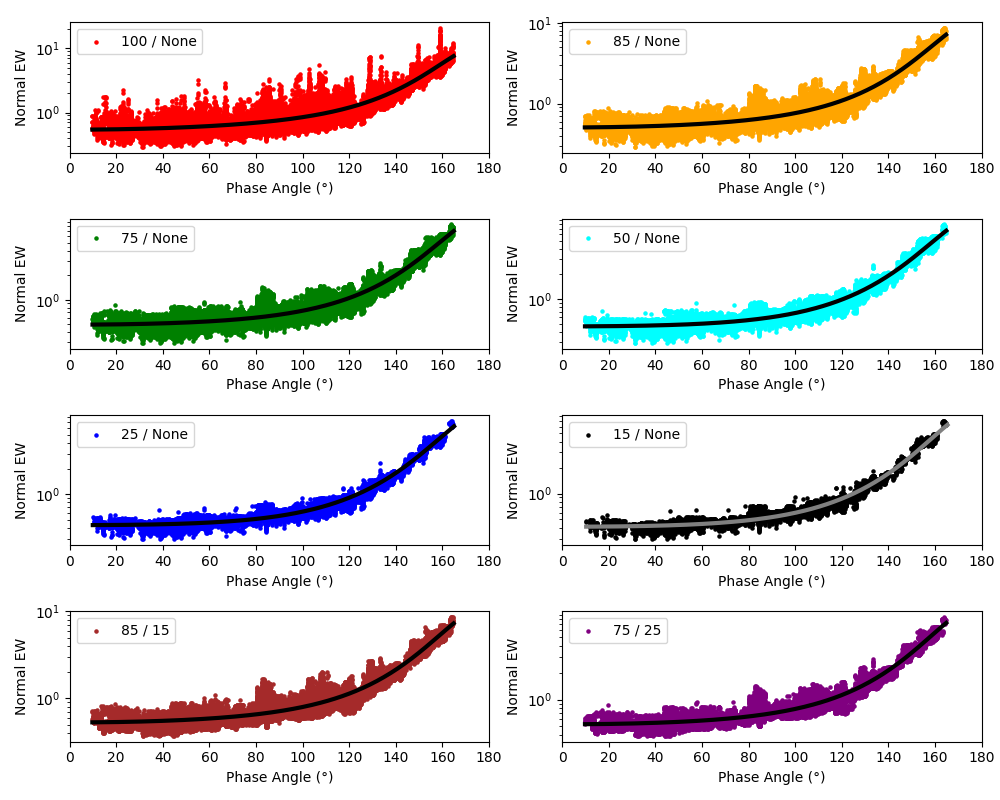

*** 100 / None: red
g1 = -0.657 / scale1 =  1.643 / weight1 = 0.628
g2 = -0.035 / scale2 =  0.972 / weight2 = 0.372
*** 85 / None: orange
g1 = -0.653 / scale1 =  1.584 / weight1 = 0.656
g2 = -0.008 / scale2 =  0.832 / weight2 = 0.344
*** 75 / None: green
g1 = -0.652 / scale1 =  1.564 / weight1 = 0.667
g2 =  0.003 / scale2 =  0.781 / weight2 = 0.333
*** 50 / None: cyan
g1 = -0.647 / scale1 =  1.516 / weight1 = 0.689
g2 =  0.024 / scale2 =  0.683 / weight2 = 0.311
*** 25 / None: blue
g1 = -0.648 / scale1 =  1.431 / weight1 = 0.698
g2 =  0.030 / scale2 =  0.620 / weight2 = 0.302
*** 15 / None: black
g1 = -0.652 / scale1 =  1.381 / weight1 = 0.698
g2 =  0.026 / scale2 =  0.599 / weight2 = 0.302
*** 85 / 15: brown
g1 = -0.649 / scale1 =  1.640 / weight1 = 0.654
g2 = -0.007 / scale2 =  0.866 / weight2 = 0.346
*** 75 / 25: purple
g1 = -0.647 / scale1 =  1.646 / weight1 = 0.662
g2 =  0.002 / scale2 =  0.839 / weight2 = 0.338


In [32]:
plot_various_quants(obsdata_0_1)

# Check for Need for Mu or Mu0 Adjustment

In [33]:
obsdata_limited = limit_by_quant(obsdata_0_1, 50, None)
params_limited, _, _ = fit_hg_phase_function(2, None, obsdata_limited)
print('1 degree slices, 50% cutoff')
print_hg_params(params_limited)

1 degree slices, 50% cutoff
g1 = -0.647 / scale1 =  1.516 / weight1 = 0.689
g2 =  0.024 / scale2 =  0.683 / weight2 = 0.311


<IPython.core.display.Javascript object>


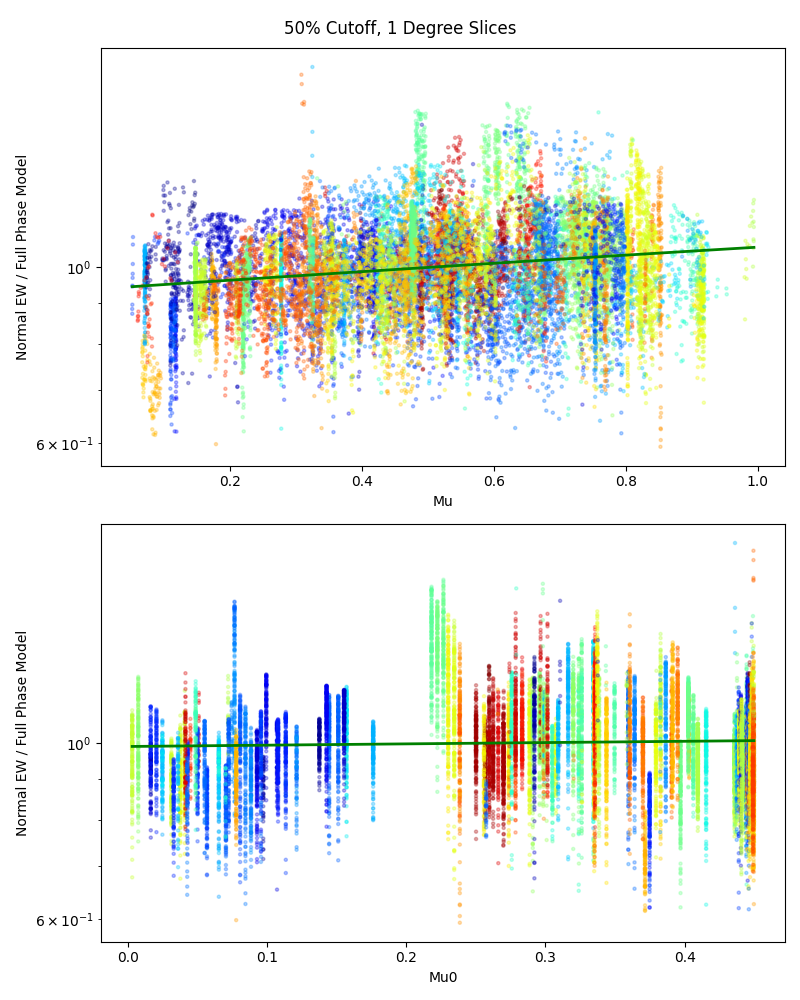

In [34]:
plot_ratio_vs_mu_mu0(obsdata_limited, params_limited, 
                     '50% Cutoff, 1 Degree Slices', order=1)

<IPython.core.display.Javascript object>


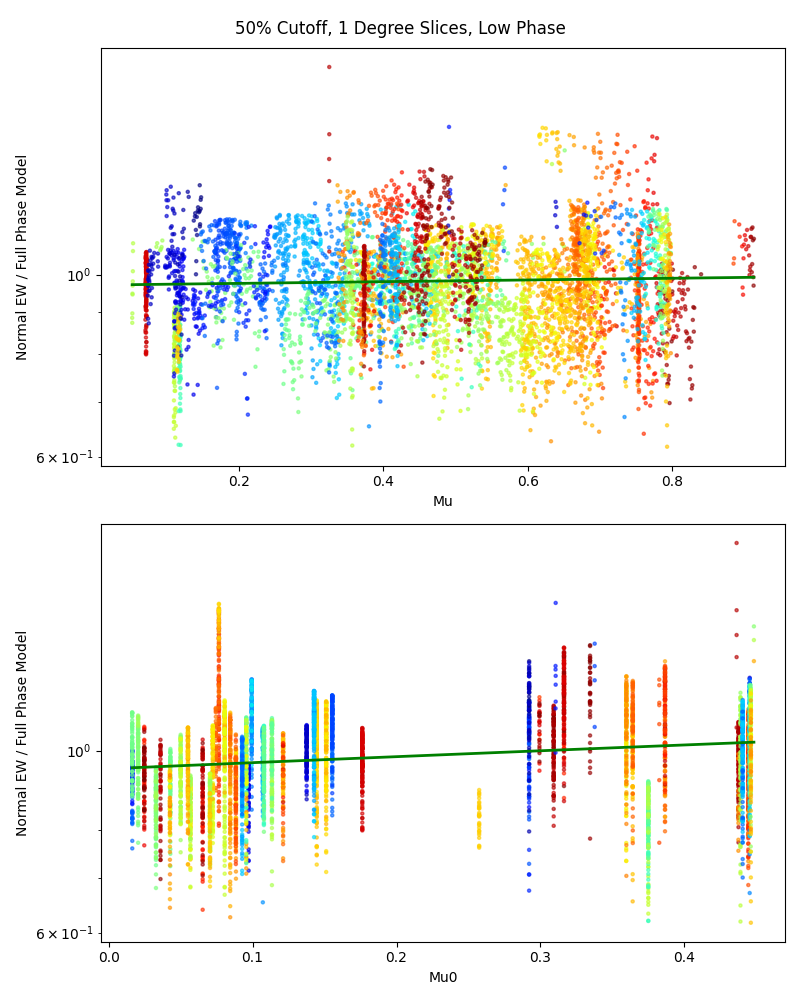

In [35]:
obsdata_limited_low_phase = obsdata_limited[obsdata_limited['Mean Phase'] <= 60].copy()
# obsdata_0_1_low_ei = obsdata_0_1_low_phase[((obsdata_0_1_low_phase['Mean Emission']-90).abs() <= 6) |
#                                             (obsdata_0_1_low_phase['Incidence'] >= 84)].copy()
plot_ratio_vs_mu_mu0(obsdata_limited_low_phase, params_limited, 
                     '50% Cutoff, 1 Degree Slices, Low Phase', order=1)

# Check for Time Variation

<IPython.core.display.Javascript object>


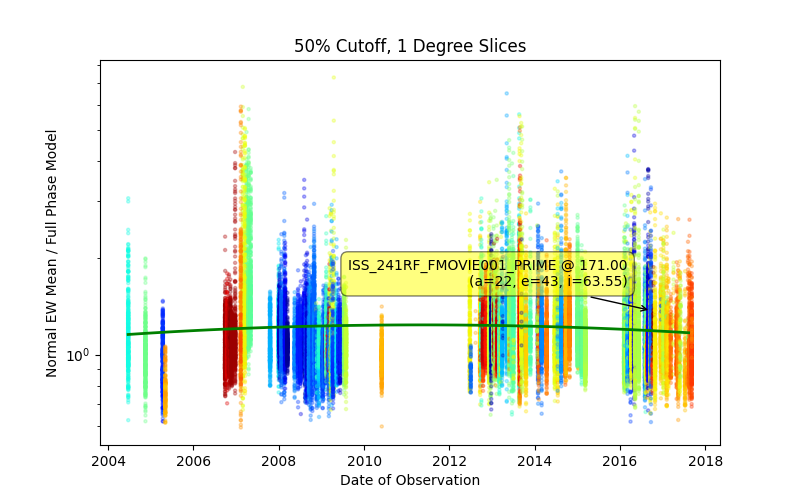

In [36]:
plot_points_phase_time(obsdata_0_1, params_limited, title='50% Cutoff, 1 Degree Slices', time_fit=2)